# LLM - Visual captioning

## Imagen imagetext
- https://cloud.google.com/vertex-ai/docs/generative-ai/image/image-captioning

In [1]:

import vertexai
from google.cloud import bigquery
from tools import *

# @title Parameters
LOCATION = "us-central1" #@param {type:"string"}

PROJECT_ID = "ml-demo-384110"  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location=LOCATION)
client = bigquery.Client(project=PROJECT_ID)

%load_ext google.cloud.bigquery

In [2]:
#%pip uninstall langflow -y

%pip install --upgrade --user google-cloud-aiplatform>=1.29.0
#%pip install --upgrade pip

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# @title Setup

import json
import requests
import time

from IPython import display
import base64

from vertexai.preview.vision_models import Image


###
# Visual Question Answering (VQA) to get image information
##
from ratelimit import limits, sleep_and_retry

from tools import *


@sleep_and_retry
@limits(calls=400, period=60, raise_on_limit=False)
def visual_qa(
    prompt: str,
    sampleCount: int,
    image: bytes
    ):
    from vertexai.preview.vision_models import Image

    return ask_question(
        Image(image),
        prompt,
        number_of_results=sampleCount)

###
#Visual captioning is available in the following languages:
# English (en)
# French (fr)
# German (de)
# Italian (it)
# Spanish (es)
##
from ratelimit import limits, sleep_and_retry

from tools import *


@sleep_and_retry
@limits(calls=400, period=60, raise_on_limit=False)
def visual_captioning(
    sampleCount: int,
    language: str, 
    # English (en), French (fr), German (de), Italian (it), Spanish (es)
    image: bytes
    ):
    from vertexai.preview.vision_models import Image

    
    return get_captions(
        Image(image),
        sampleCount,
        language)

<Response [200]>


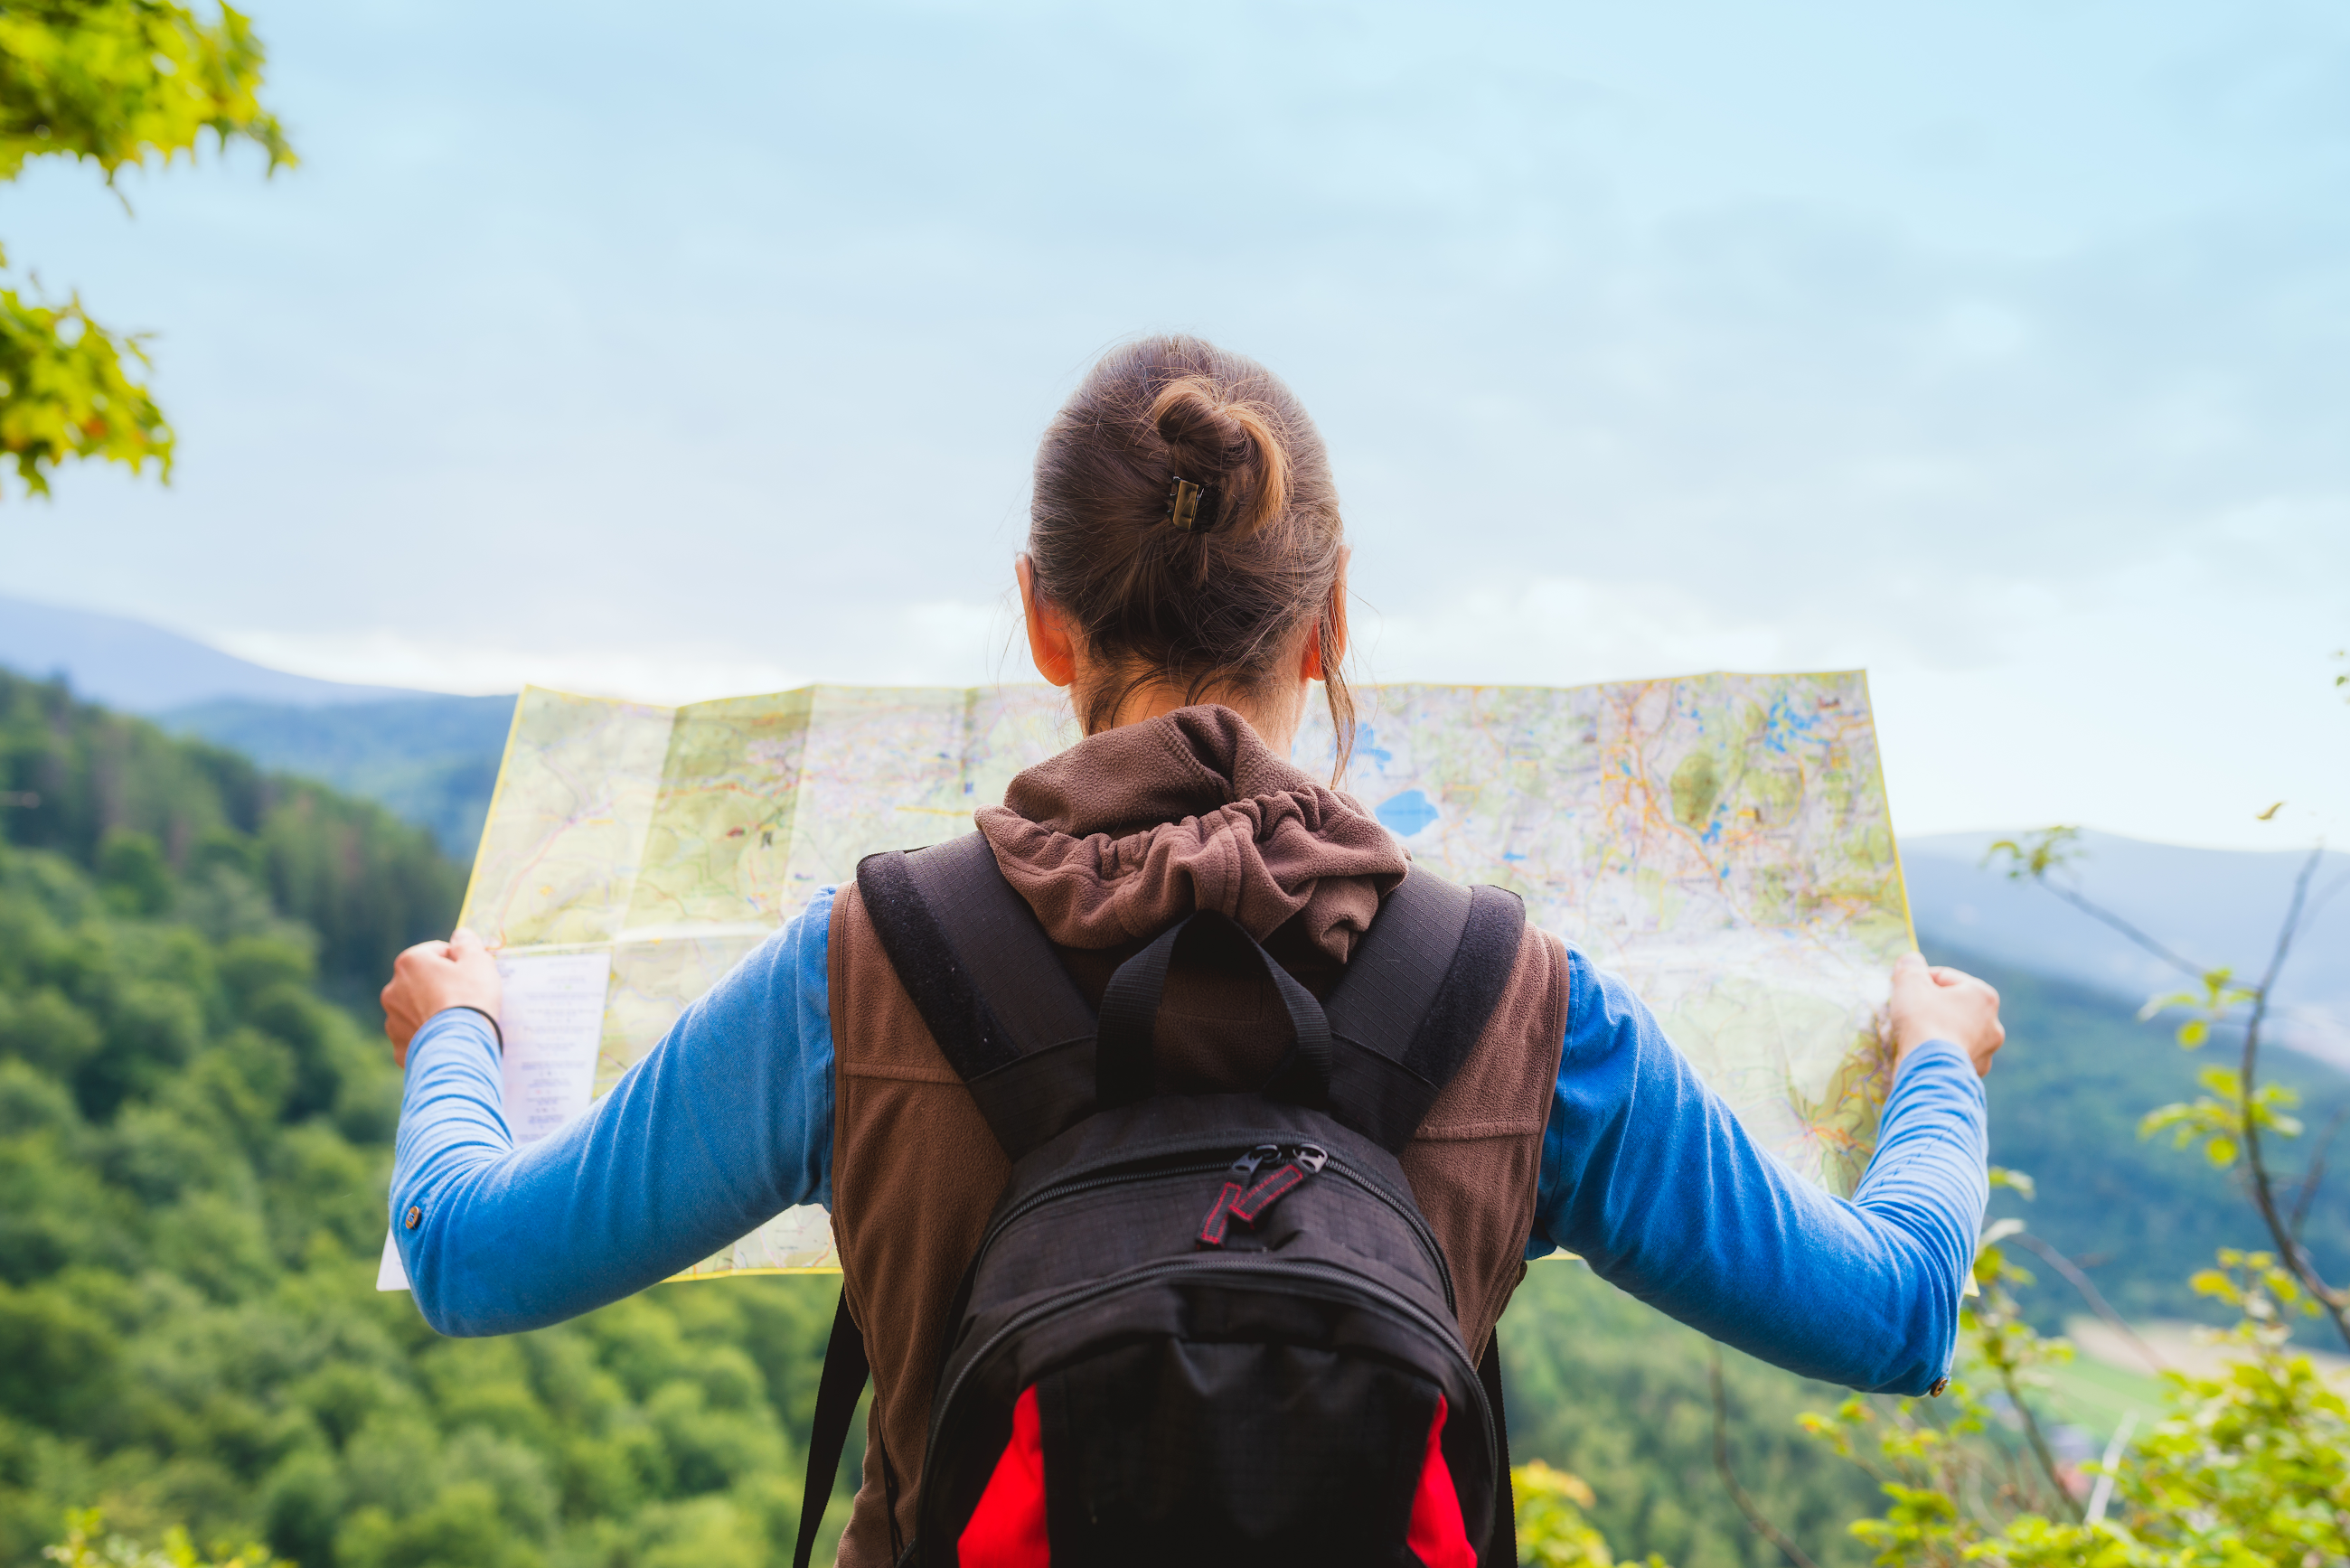

In [12]:



from vertexai.preview.vision_models import Image


import os
import requests

def download_image(url):
    """Downloads an image from the specified URL."""

    # Send a get request to the url
    response = requests.get(url)

    print(response)
    # If the request is successful
    if response.status_code == 200:

        # Define image related variables
        image_path = os.path.basename(url)
        image_bytes = response.content
        image_type = response.headers['Content-Type'].split('/')[1]

        # Check for image type, currently only PNG or JPEG format are supported
        if image_type in ("png", "jpg", "jpeg"):
            return image_bytes
            # Write image data to a file
            with open(image_path, "wb") as f:
                f.write(image_bytes)
            return image_path
        else:
            raise Exception("Image can only be in PNG or JPEG format")

    else:
        raise Exception(f"Failed to download image from {url}")
# Download an image
url = "https://storage.googleapis.com/gweb-cloudblog-publish/images/GettyImages-871168786.max-2600x2600.jpg"
#image_path = download_image(url)

from vertexai.preview.vision_models import Image

user_image = Image(download_image(url))
# Load the newly downloaded image
#user_image = Image.load_from_file(image_path)
user_image.show()



In [14]:
from vertexai.preview.vision_models import ImageQnAModel

image_qna_model = ImageQnAModel.from_pretrained("imagetext@001")

def ask_question(
    user_image,
    question,
    number_of_results=1):
  # Ask a question about the image
  return ", ".join(image_qna_model.ask_question(
    image=user_image,
    question=question,
    number_of_results=number_of_results
  ))

ask_question(user_image, "what is in the image ")

'map'

In [21]:
from grpc import RpcError
from vertexai.preview.vision_models import ImageCaptioningModel

image_captioning_model = ImageCaptioningModel.from_pretrained("imagetext")
#debug_user_image = None
def get_captions(
        user_image,
        number_of_results=1,
        language='en'):
    global debug_user_image 
    debug_user_image =  user_image
# Generate the visual captions for the image
    try:
        res = image_captioning_model.get_captions(
                image=user_image,
                number_of_results=number_of_results,
                language=language,
            )
        
        return ", ".join(res)
    except RpcError  as rpc_e:        
        print('RpcError Failed to get_captions: '+ str(rpc_e))
    
    except Exception as e: # work on python 3.x
        print('Failed to get_captions: '+ str(e))
    
    return ""


get_captions(user_image)


'a woman with a backpack is looking at a map'

In [19]:
get_captions(user_image,1, "fr")



'une femme avec un sac à dos regarde une carte'

In [11]:
debug_user_image

In [7]:
from tools import *


bucket = "ml-demo-384110-bucket"




In [43]:
%%bigquery df
      SELECT distinct uri, Id,
      FROM `immo_us_enriched.image_cloudvision_labels_1k` 
      where uri not in (
            SELECT uri FROM `ml-demo-384110.immo_us.visual_captioning` 
            where caption_fr != "" and caption_en != "" 
            )
            #limit 100



Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
%%bigquery df
      SELECT uri, Id,
      FROM `immo_us_enriched.image_cloudvision_labels_1k`  


Query is running:   0%|          |

Downloading:   0%|          |

In [19]:
df

uri                  Id
0    gs://ml-demo-384110-bucket/dataset/immo/images...  ag060811-378090001
1    gs://ml-demo-384110-bucket/dataset/immo/images...  ag060811-378090001
2    gs://ml-demo-384110-bucket/dataset/immo/images...  ag060811-378090001
3    gs://ml-demo-384110-bucket/dataset/immo/images...  ag060811-378090001
4    gs://ml-demo-384110-bucket/dataset/immo/images...  ag060811-378090001
..                                                 ...                 ...
995  gs://ml-demo-384110-bucket/dataset/immo/images...      safti-1-886992
996  gs://ml-demo-384110-bucket/dataset/immo/images...      safti-1-886992
997  gs://ml-demo-384110-bucket/dataset/immo/images...      safti-1-886992
998  gs://ml-demo-384110-bucket/dataset/immo/images...      safti-1-886992
999  gs://ml-demo-384110-bucket/dataset/immo/images...      safti-1-886992

[1000 rows x 2 columns]

In [25]:
from ratelimit import limits, sleep_and_retry

from tools import *


def add_images_caption_to_df(df, language="en", bucket_name="ml-demo-384110-bucket"):


    df[f'caption_{language}'] = df.uri.map(lambda uri_name:

                                           visual_captioning(
                                               1,
                                               language,
                                               read_bytes_from_gcs(
                                                   bucket,
                                                   uri_name.replace(
                                                       f"gs://{bucket_name}/", "")
                                               )
                                           )
                                           )

    return df


@sleep_and_retry
@limits(calls=400, period=60, raise_on_limit=False)
def add_images_visual_caption_to_df(df, prompt, name, number_of_answer, language="en", bucket_name="ml-demo-384110-bucket"):

    print(f'{name} : {prompt} ')
    try:
        df[f'caption_{name}'] = df.uri.map(
            lambda uri_name:
                visual_qa(
                    prompt,
                    number_of_answer,
                    read_bytes_from_gcs(
                        bucket,
                        uri_name.replace(
                            f"gs://{bucket_name}/", "")
                    )
                )
        )
    except:
      print("An exception occurred")

    
    return df

In [11]:
from bq import save_bq

bucket = "ml-demo-384110-bucket"

In [16]:

base_image_path = "dataset/immo/images/_photos_realestate_2023-02_product-1303126-3.jpg"




visual_qa("what is the room ?", 
            1, 
            read_bytes_from_gcs(bucket, base_image_path)
                            )
                            


'bedroom'

In [23]:
BQ_DATASET_NAME = 'immo_us' 

def process(df):
    for id in df.Id :
        print(id)
        df_vqa = df[df["Id"] == id]

        df_vqa = add_images_visual_caption_to_df(df_vqa, "what is the room ?", "location", 1)
        df_vqa = add_images_visual_caption_to_df(df_vqa, "floor material", "floor", 1)
        df_vqa = add_images_visual_caption_to_df(df_vqa, "wall material", "wall", 1)

        df_vqa = add_images_visual_caption_to_df(df_vqa, "describe", "describe", 3)
        df_vqa = add_images_visual_caption_to_df(df_vqa, "describe windows", "windows", 3)
        df_vqa = add_images_visual_caption_to_df(df_vqa, "text", "text", 3, "en")
        df_vqa = add_images_visual_caption_to_df(df_vqa, "Level of finish of the place", "finish_level", 3)
        
        df_vqa = add_images_caption_to_df(df_vqa, "en")
        df_vqa = add_images_caption_to_df(df_vqa, "fr")

        df_vqa["update_time"] = update_time()

        print(f"SAVE index chunk : {id}")
        save_bq(df_vqa, 
                table_id=PROJECT_ID + "." +BQ_DATASET_NAME +".visual_captioning_api" , 
                project_id=PROJECT_ID)

process(df)

ag060811-378090001
location : what is the room ? 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


floor : floor material 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


wall : wall material 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


describe : describe 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


windows : describe windows 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


text : text 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


finish_level : Level of finish of the place 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

SAVE index chunk : ag060811-378090001
save_bq


100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]


ag060811-378090001
location : what is the room ? 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


floor : floor material 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


wall : wall material 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


describe : describe 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


windows : describe windows 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


text : text 


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_6281/945007173.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{name}'] = df.uri.map(


finish_level : Level of finish of the place 


DataCorruption: Checksum mismatch while downloading:

  https://storage.googleapis.com/download/storage/v1/b/ml-demo-384110-bucket/o/dataset%2Fimmo%2Fimages%2F_60811_378090001_photos_13.jpg?alt=media

The X-Goog-Hash header indicated an MD5 checksum of:

  QrfxKG8X/7BAtFNjWUasvA==

but the actual MD5 checksum of the downloaded contents was:

  bK2sAjhDqoIR1ILt1SXjyA==


In [44]:
df.describe()

uri              Id
count                                                 362             362
unique                                                362              34
top     gs://ml-demo-384110-bucket/dataset/immo/images...  safti-1-872376
freq                                                    1              20

In [47]:
BQ_DATASET_NAME = 'immo_us' 
BQ_TABLE_NAME = 'visual_captioning'
project_table = PROJECT_ID + "." +BQ_DATASET_NAME +"." + BQ_TABLE_NAME



def process(df):
    count = 0
    
    for id in df.Id.drop_duplicates().tolist() :
        print(id)
        print(f' count : {count}')
        df_vqa = df[df["Id"] == id]
        
        df_vqa = add_images_caption_to_df(df_vqa, "en")
        df_vqa = add_images_caption_to_df(df_vqa, "fr")

        df_vqa["update_time"] = update_time()

        print(f"SAVE index chunk : {id}")
        save_bq(df_vqa, table_id=project_table, project_id=PROJECT_ID)
        count = count + 1

process(df)

ag340369-381741688
 count : 0


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 500 Internal error encountered.
SAVE index chunk : ag340369-381741688
save_bq


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()
100%|██████████| 1/1 [00:00<00:00, 6278.90it/s]


ag753296-384794585
 count : 1


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 500 Internal error encountered.
SAVE index chunk : ag753296-384794585
save_bq


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()
100%|██████████| 1/1 [00:00<00:00, 1336.62it/s]


apimo-7406943
 count : 2


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 500 Internal error encountered.
SAVE index chunk : apimo-7406943
save_bq


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()
100%|██████████| 1/1 [00:00<00:00, 384.90it/s]


apimo-82421909
 count : 3


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 500 Internal error encountered.
SAVE index chunk : apimo-82421909
save_bq


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()
100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]


apimo-82501425
 count : 4


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 500 Internal error encountered.
Failed to get_captions: 500 Internal error encountered.


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()


SAVE index chunk : apimo-82501425
save_bq


100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


safti-1-783847
 count : 5


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-783847
save_bq


100%|██████████| 1/1 [00:00<00:00, 3368.92it/s]


safti-1-787129
 count : 6


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-787129
save_bq


100%|██████████| 1/1 [00:00<00:00, 1663.75it/s]


safti-1-787853
 count : 7


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-787853
save_bq


100%|██████████| 1/1 [00:00<00:00, 1733.90it/s]


safti-1-790273
 count : 8
Failed to get_captions: 400 Media reasoning failed with the following error: The response is blocked, as it may violate our policies. If you believe this is an error, please send feedback to your account team. Error Code: 63429089


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 400 Media reasoning failed with the following error: The response is blocked, as it may violate our policies. If you believe this is an error, please send feedback to your account team. Error Code: 63429089


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()


SAVE index chunk : safti-1-790273
save_bq


100%|██████████| 1/1 [00:00<00:00, 3204.20it/s]


safti-1-791682
 count : 9


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-791682
save_bq


100%|██████████| 1/1 [00:00<00:00, 1626.33it/s]


safti-1-795927
 count : 10
Failed to get_captions: 400 Media reasoning failed with the following error: The response is blocked, as it may violate our policies. If you believe this is an error, please send feedback to your account team. Error Code: 49114662


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 400 Media reasoning failed with the following error: The response is blocked, as it may violate our policies. If you believe this is an error, please send feedback to your account team. Error Code: 49114662


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()


SAVE index chunk : safti-1-795927
save_bq


100%|██████████| 1/1 [00:00<00:00, 5210.32it/s]


safti-1-796292
 count : 11


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-796292
save_bq


100%|██████████| 1/1 [00:00<00:00, 2890.63it/s]


safti-1-800805
 count : 12


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-800805
save_bq


100%|██████████| 1/1 [00:00<00:00, 3266.59it/s]


safti-1-807163
 count : 13


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-807163
save_bq


100%|██████████| 1/1 [00:00<00:00, 1161.54it/s]


safti-1-820609
 count : 14


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-820609
save_bq


100%|██████████| 1/1 [00:00<00:00, 5555.37it/s]


safti-1-826635
 count : 15


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-826635
save_bq


100%|██████████| 1/1 [00:00<00:00, 9597.95it/s]


safti-1-831317
 count : 16


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-831317
save_bq


100%|██████████| 1/1 [00:00<00:00, 2933.08it/s]


safti-1-842750
 count : 17


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-842750
save_bq


100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


safti-1-842801
 count : 18


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-842801
save_bq


100%|██████████| 1/1 [00:00<00:00, 4969.55it/s]


safti-1-843783
 count : 19


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-843783
save_bq


100%|██████████| 1/1 [00:00<00:00, 4975.45it/s]


safti-1-845019
 count : 20


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-845019
save_bq


100%|██████████| 1/1 [00:00<00:00, 5433.04it/s]


safti-1-850124
 count : 21


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-850124
save_bq


100%|██████████| 1/1 [00:00<00:00, 1412.70it/s]


safti-1-864223
 count : 22


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-864223
save_bq


100%|██████████| 1/1 [00:00<00:00, 4614.20it/s]


safti-1-864295
 count : 23


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-864295
save_bq


100%|██████████| 1/1 [00:00<00:00, 4181.76it/s]


safti-1-866510
 count : 24


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 500 Internal error encountered.


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()


SAVE index chunk : safti-1-866510
save_bq


100%|██████████| 1/1 [00:00<00:00, 4766.25it/s]


safti-1-867453
 count : 25
Failed to get_captions: 400 Media reasoning failed with the following error: The response is blocked, as it may violate our policies. If you believe this is an error, please send feedback to your account team. Error Code: 49114662


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 400 Media reasoning failed with the following error: The response is blocked, as it may violate our policies. If you believe this is an error, please send feedback to your account team. Error Code: 49114662


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()


SAVE index chunk : safti-1-867453
save_bq


100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]


safti-1-868974
 count : 26


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-868974
save_bq


100%|██████████| 1/1 [00:00<00:00, 1984.06it/s]


safti-1-869658
 count : 27


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-869658
save_bq


100%|██████████| 1/1 [00:00<00:00, 2673.23it/s]


safti-1-872376
 count : 28


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-872376
save_bq


100%|██████████| 1/1 [00:00<00:00, 1931.08it/s]


safti-1-877653
 count : 29


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-877653
save_bq


100%|██████████| 1/1 [00:00<00:00, 7002.18it/s]


safti-1-882504
 count : 30


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:


Failed to get_captions: 500 Internal error encountered.
SAVE index chunk : safti-1-882504
save_bq


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqa["update_time"] = update_time()
100%|██████████| 1/1 [00:00<00:00, 2054.02it/s]


safti-1-882864
 count : 31


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-882864
save_bq


100%|██████████| 1/1 [00:00<00:00, 11781.75it/s]


safti-1-884151
 count : 32


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-884151
save_bq


100%|██████████| 1/1 [00:00<00:00, 3979.42it/s]


safti-1-886992
 count : 33


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/3904732032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'caption_{language}'] = df.uri.map(lambda uri_name:
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_23233/1628302046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a cop

SAVE index chunk : safti-1-886992
save_bq


100%|██████████| 1/1 [00:00<00:00, 4341.93it/s]


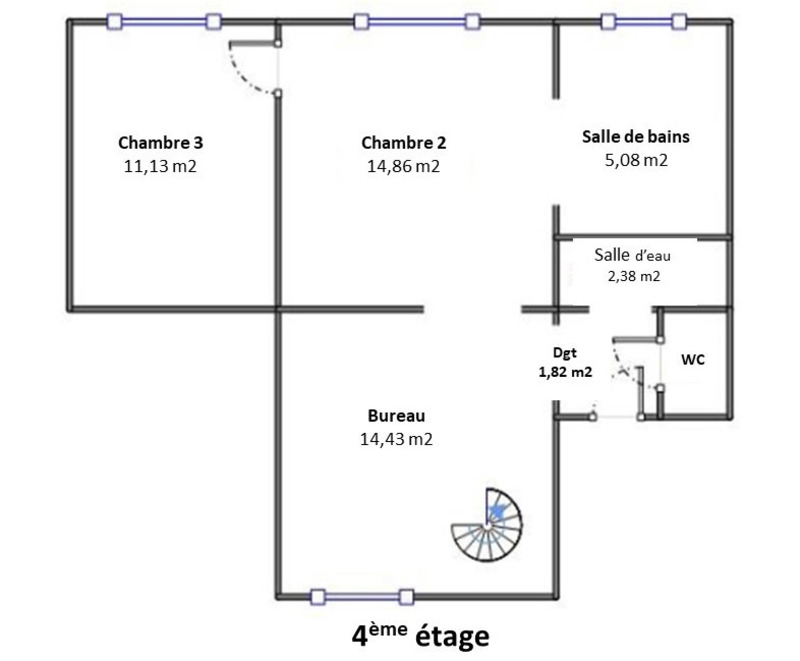

InternalServerError: 500 Internal error encountered.

In [36]:
debug_user_image.show()
get_captions(debug_user_image, 3, "fr")

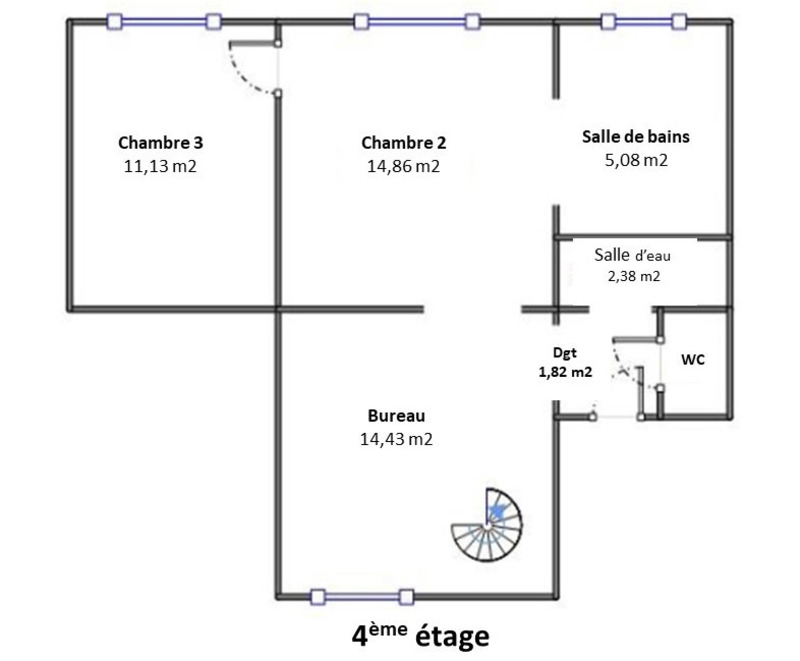

'a floor plan of a house with three bedrooms and a spiral staircase ., a floor plan of a house with a spiral staircase, a floor plan of a house with three bedrooms and a spiral staircase'

In [37]:
debug_user_image.show()
get_captions(debug_user_image, 3, "en")